In [13]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.python.framework import ops
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

In [14]:
def load_dataset():
    train_dataset = pd.read_csv('./data/titanic_train.csv')
    # Normalize Age and Fare Fields
    train_dataset['Age'] = train_dataset['Age'].fillna(train_dataset['Age'].mean())
    train_dataset['Age'] = (train_dataset['Age'] - train_dataset['Age'].mean())/train_dataset['Age'].std()
    
    train_dataset['Fare'] = (train_dataset['Fare'] - train_dataset['Fare'].mean())/train_dataset['Fare'].std()
    train_dataset = train_dataset.drop(['PassengerId','Name','Ticket', 'Cabin'], axis=1)
    train_dataset['Embarked'] = train_dataset['Embarked'].fillna('S')
    train_dataset["Embarked"] = train_dataset["Embarked"].replace(["S","C","Q"], [1,2,3]).values
    train_dataset["Sex"] = train_dataset["Sex"].replace(["male","female"], [0,1]).values
    train_set_x_orig = np.array(train_dataset.iloc[:, 1:]) # your train set features
    train_set_y_orig = np.array(train_dataset['Survived']) # your train set labels

    test_dataset = pd.read_csv('./data/titanic_test.csv')
    # Normalize Age and Fare Fields
    test_dataset['Age'] = test_dataset['Age'].fillna(test_dataset['Age'].mean())
    test_dataset['Age'] = (test_dataset['Age'] - test_dataset['Age'].mean())/test_dataset['Age'].std()
    test_dataset['Fare'] = (test_dataset['Fare'] - test_dataset['Fare'].mean())/test_dataset['Fare'].std()
    test_dataset["Embarked"] = test_dataset["Embarked"].replace(["S","C","Q"], [1,2,3]).values
    test_dataset["Sex"] = test_dataset["Sex"].replace(["male","female"], [0,1]).values

    test_dataset = test_dataset.drop(['Name','Ticket', 'Cabin'], axis=1)

    test_set_x_orig = np.array(test_dataset.iloc[:, 1:]) # your test set features
    passenger_ids = np.array(test_dataset['PassengerId']) # your test set features
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, passenger_ids

# Read in datafile
X, Y, X_test, passengerIds = load_dataset()

In [15]:
def create_placeholders(n_x, n_y):
    X = tf.placeholder(dtype = tf.float32, shape = [n_x, None])
    Y = tf.placeholder(dtype = tf.float32, shape = [n_y, None])
    
    return X, Y

def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

# Build train and dev set
train_sample_size = int(len(X) * 0.2)
X_train = X[:len(X) - train_sample_size].T
X_dev = X[len(X) - train_sample_size:, ].T
Y_train = Y[0][:len(X) - train_sample_size]
Y_dev = Y[0][len(X) - train_sample_size:]


Y_train = convert_to_one_hot(Y_train, 2)
Y_dev = convert_to_one_hot(Y_dev, 2)

print(Y_train)

[[1. 0. 0. ... 0. 1. 0.]
 [0. 1. 1. ... 1. 0. 1.]]


In [16]:
tf.set_random_seed(1)
def initialize_network():
    W1 = tf.get_variable("W1", [8,7], initializer = tf.contrib.layers.xavier_initializer(seed = 4))
    b1 = tf.get_variable("b1", [8,1], initializer = tf.zeros_initializer())
    W2 = tf.get_variable("W2", [12,8], initializer = tf.contrib.layers.xavier_initializer(seed = 4))
    b2 = tf.get_variable("b2", [12,1], initializer = tf.zeros_initializer())
    W3 = tf.get_variable("W3", [2,12], initializer = tf.contrib.layers.xavier_initializer(seed = 4))
    b3 = tf.get_variable("b3", [2,1], initializer = tf.zeros_initializer())
    parameters = {
        "W1": W1,
        "b1": b1,
        "W2": W2,
        "b2": b2,
        "W3": W3,
        "b3": b3
    }
    return parameters

In [32]:
def forward_propagation(X, parameters):
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    b3 = parameters["b3"]
    
    Z1 = tf.add(tf.matmul(W1,X), b1)
    A1 = tf.nn.dropout(tf.nn.relu(Z1), keep_prob=0.8)
    Z2 = tf.add(tf.matmul(W2, A1), b2)
    A2 = tf.nn.dropout(tf.nn.relu(Z2), keep_prob=0.8)
    Z3 = tf.add(tf.matmul(W3, A2), b3)
    
    return Z3 

def compute_cost(Z3, Y):
    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = logits, labels = labels))
    return cost

In [33]:
def model(X_train, Y_train, X_dev, Y_dev, X_test, learning_rate = 0.005, num_iterations = 10000, print_cost = True):
    tf.reset_default_graph()
    X, Y = create_placeholders(7,2)
    parameters = initialize_network()
    Z3 = forward_propagation(X, parameters)
    predictions = tf.nn.softmax(Z3)
    cost = compute_cost(Z3, Y)
    costs = []
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    
    init = tf.global_variables_initializer()
    init_l = tf.local_variables_initializer()
    sess = tf.Session()
    with tf.Session() as sess:
        sess.run(init)
        each_cost = 0
        for i in range(num_iterations):
            _, each_cost = sess.run([optimizer, cost], feed_dict = {X: X_train, Y:Y_train})
            if print_cost and i%5000 == 0:
                print("Cost at %i is %f"%(i, each_cost))
            if i % 10 == 0:
                costs.append(each_cost)
        
        #Metrics business
        output = tf.argmax(Z3)
        labels = tf.argmax(Y)
        correct_prediction = tf.equal(output, labels)
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
       
        #training and testing accuracy
        train_accuracy = accuracy.eval({X: X_train, Y:Y_train})
        dev_accuracy = accuracy.eval({X: X_dev, Y: Y_dev})
        #precision and recall
        precisions = tf.metrics.precision(labels, output)
        recalls = tf.metrics.recall(labels, output)
        
        sess.run(tf.local_variables_initializer())
        precisions = sess.run(precisions, feed_dict={X: X_dev, Y: Y_dev})[1]
        recalls = sess.run(recalls, feed_dict={X: X_dev, Y: Y_dev})[1]
        f1_score = 2 * precisions * recalls / (precisions + recalls)
        
        metrics = {
            "train_accuracy": train_accuracy,
            "dev_accuracy": dev_accuracy,
            "precision": precisions,
            "recall": recalls,
            "f1_score": f1_score
        }
        
        
        return metrics, costs, sess.run(parameters), sess.run(output, feed_dict={X: X_test}).squeeze()


In [34]:
metrics, costs, parameters, Y_pred = model(X_train, Y_train, X_dev, Y_dev, X_test.T, num_iterations=10000, learning_rate = 0.005, print_cost = False)
print(metrics)

{'recall': 0.6031746, 'train_accuracy': 0.8218794, 'precision': 0.8604651, 'dev_accuracy': 0.8033708, 'f1_score': 0.7092055625453085}


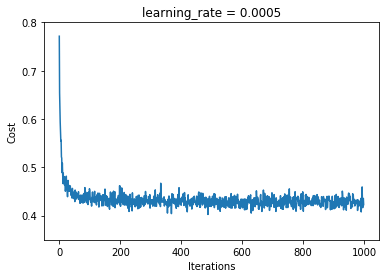

In [35]:
plt.plot(costs)
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.ylim(0.35, 0.8)
plt.title("learning_rate = 0.0005")
plt.show()

In [36]:
output = pd.DataFrame()
output['PassengerId'] = passengerIds
output['Survived'] = Y_pred.astype(int)
output.to_csv('./prediction.csv', index=False)
output.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


### Current Kaggle Score: 0.77990